Step 0: A sentiment analyzer that reviews messages from Amazon to determine whether positive or Negative. Acts as a decision making tool.

Step 1: IMPORT LIBRARIES AND MODULES

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [4]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Step 2: LOAD DATASET

In [5]:
df=pd.read_csv("amazon_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


Step 3: TEXT PREPROCESSING

In [6]:
#converting text to lowercase
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [7]:
# STOPWORDS
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Rarewords

drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [9]:
# TOKENIZATION

# nltk.download("punkt")
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, sprung, higher, capacity, th...
3    [think, worked, greathad, diff, bran, gb, card...
4    [bought, retail, packaging, arrived, legit, or...
Name: reviewText, dtype: object

In [10]:
# LEMMATIZATION

# nltk.download('wordnet')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['reviewText'].head(10)

0                                                issue
1    purchased device worked advertised never much ...
2    work expected sprung higher capacity think mad...
3    think worked greathad diff bran gb card went s...
4    bought retail packaging arrived legit orange e...
5    mini storage doesnt anything else supposed pur...
6    phone never skip beat file transfer speedy cor...
7    hard believe affordable digital become gb devi...
8    work htc rezound running short space gb sandis...
9    galaxy super fast card totally happy happy sti...
Name: reviewText, dtype: object

In [11]:
#STEMMING
# create an instance of PorterStemmer
porter = PorterStemmer()

# define a function to apply stemming to each word in a sentence
def stem_words(text):
    return " ".join([porter.stem(word) for word in text.split()])

# apply stemming to the 'reviewText' column in your DataFrame
df['reviewText'] = df['reviewText'].apply(stem_words)

# display the first 10 rows of the 'reviewText' column
df['reviewText'].head(10)


0                                                 issu
1    purchas devic work advertis never much phone m...
2    work expect sprung higher capac think made bit...
3    think work greathad diff bran gb card went sou...
4    bought retail packag arriv legit orang envelop...
5    mini storag doesnt anyth els suppos purchas ad...
6    phone never skip beat file transfer speedi cor...
7    hard believ afford digit becom gb devic one qu...
8    work htc rezound run short space gb sandisk or...
9    galaxi super fast card total happi happi still...
Name: reviewText, dtype: object

Step 4: TEXT VISUALIZATION

In [12]:
#term frequency

tf = df["reviewText"].apply(lambda x: pd.Series(x).value_counts()).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()


,words,tf
0,issu,2.00
1,purchas devic work advertis never much phone m...,1.00
2,work expect sprung higher capac think made bit...,1.00
3,think work greathad diff bran gb card went sou...,1.00
4,bought retail packag arriv legit orang envelop...,1.00


In [13]:
tf.shape

(4911, 2)

In [14]:
tf["tf"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count   4911.00
mean       1.00
std        0.03
min        1.00
5%         1.00
10%        1.00
25%        1.00
50%        1.00
75%        1.00
80%        1.00
90%        1.00
95%        1.00
99%        1.00
max        2.00
Name: tf, dtype: float64

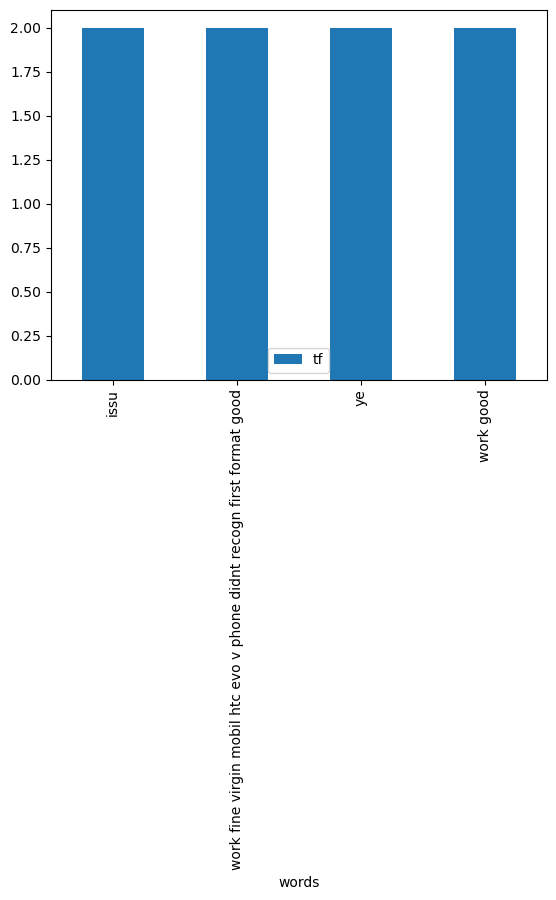

In [15]:
# Barplot

tf[tf["tf"] > 1].plot.bar(x="words", y="tf")
plt.show()

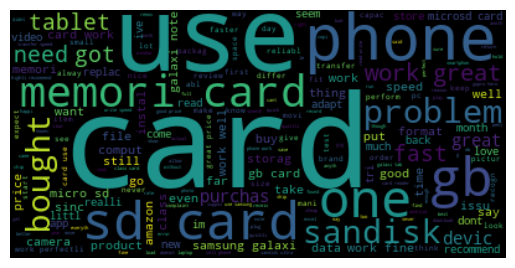

In [16]:
# Wordcloud

#convert all values in the reviewtext column to strings
df["reviewText"] = df["reviewText"].astype(str)

text = " ".join(i for i in df.reviewText)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Step 5: ANALYSIS AND TRAINING

In [17]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issu,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchas devic work advertis never much phone m...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expect sprung higher capac think made bit...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think work greathad diff bran gb card went sou...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packag arriv legit orang envelop...,5.00,best deal around,1373673600,2013-07-13,513,0,0


In [18]:
 nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [20]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [21]:
df["reviewText"].apply(lambda x: x.upper())

0                                                    ISSU
1       PURCHAS DEVIC WORK ADVERTIS NEVER MUCH PHONE M...
2       WORK EXPECT SPRUNG HIGHER CAPAC THINK MADE BIT...
3       THINK WORK GREATHAD DIFF BRAN GB CARD WENT SOU...
4       BOUGHT RETAIL PACKAG ARRIV LEGIT ORANG ENVELOP...
                              ...                        
4910    BOUGHT SANDISK GB CLASS USE HTC INSPIR MONTH G...
4911    USE EXTEND CAPABL SAMSUNG GALAXI NOTE GREATLI ...
4912    GREAT CARD FAST RELIABL COME OPTION ADAPT SD S...
4913           GOOD AMOUNT SPACE STUFF WANT FIT GOPRO SAY
4914    IVE HEARD BAD THING GB MICRO SD CARD CRAP WEEK...
Name: reviewText, Length: 4915, dtype: object

In [22]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
3    {'neg': 0.0, 'neu': 0.928, 'pos': 0.072, 'comp...
4    {'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.111, 'neu': 0.672, 'pos': 0.216, 'co...
7    {'neg': 0.07, 'neu': 0.773, 'pos': 0.158, 'com...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...
Name: reviewText, dtype: object

In [23]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.27
4   0.86
5   0.00
6   0.72
7   0.65
8   0.00
9   0.60
Name: reviewText, dtype: float64

In [24]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issu,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchas devic work advertis never much phone m...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expect sprung higher capac think made bit...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think work greathad diff bran gb card went sou...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.27
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packag arriv legit orang envelop...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


Step 6: SENTIMENT MODELLING

In [25]:
#Feature Prediction
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [27]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issu,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchas devic work advertis never much phone m...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expect sprung higher capac think made bit...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think work greathad diff bran gb card went sou...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.27,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packag arriv legit orang envelop...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",mini storag doesnt anyth els suppos purchas ad...,5.00,Not a lot to really be said,1367193600,2013-04-29,588,0,0,0.00,neg
6,A26YHXZD5UFPVQ,B007WTAJTO,2K1Toaster,"[0, 0]",phone never skip beat file transfer speedi cor...,5.00,Works well,1382140800,2013-10-19,415,0,0,0.72,pos
7,A3CW0ZLUO5X2B1,B007WTAJTO,"35-year Technology Consumer ""8-tracks to 802.11""","[0, 0]",hard believ afford digit becom gb devic one qu...,5.00,32 GB for less than two sawbucks...what's not ...,1404950400,2014-10-07,62,0,0,0.65,pos
8,A2CYJO155QP33S,B007WTAJTO,4evryoung,"[1, 1]",work htc rezound run short space gb sandisk or...,5.00,Loads of room,1395619200,2014-03-24,259,1,1,0.00,neg
9,A2S7XG3ZC4VGOQ,B007WTAJTO,53rdcard,"[0, 0]",galaxi super fast card total happi happi still...,5.00,works great,1381449600,2013-11-10,393,0,0,0.60,pos


In [28]:
#ideating positive and negative sentiments in total
df["sentiment_label"].value_counts()

pos    3678
neg    1237
Name: sentiment_label, dtype: int64

In [30]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

X = df["reviewText"]
y = df["sentiment_label"]

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word')
X_w = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
X_w.toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

In [33]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [37]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [34]:
#MODEL
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y, scoring="accuracy",
                cv=5).mean()

yeni_yorum = pd.Series("this product is great")
yeni_yorum = pd.Series("look at that shit very bad")
yeni_yorum = pd.Series("it was good but I am sure that it fits me")

yeni_yorum = CountVectorizer().fit(X).transform(yeni_yorum)
log_model.predict(yeni_yorum)

array([1])

In [35]:
random_review = pd.Series(df["reviewText"].sample(1).values)
random_review

0    memori card ultra fast android phone bit costl...
dtype: object

Step 7: ACCURACY METRICS

In [38]:
#Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8331637843336723

In [39]:
#Tf-IDF WordLevel
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8022380467955239

In [43]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y)

rf_best_grid.best_params_
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [44]:
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])